<a href="https://colab.research.google.com/github/Guest-01/face-generator/blob/master/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN (Deep-Convolutional-GAN)

Tensorflow 튜토리얼을 보고 따라 만든 모델([링크](https://www.tensorflow.org/tutorials/generative/dcgan))

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

print(tf.__version__) # Version Check (2.*)

2.6.0


## Constants
해당 모델에서 사용할 설정값 모음

In [3]:
# 생성할 해상도 값 - 반드시 제곱수여야하며 훈련데이터도 그에 맞춰 스케일링 필요
# 4 이상으로 설정 시 메모리가 부족할 수 있음 주의 (코랩에서는 부족)
GENERATE_RES = 3 # (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3 # RGB

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/MyDrive/data' # 폴더가 없으면 만들어놓자
EPOCHS = 500
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate **{GENERATE_SQUARE}px** square images.")

Will generate **96px** square images.


## Utility Functions
몇가지 도우미 함수들
- 걸린 시간을 이쁘게 출력하는 함수
- 에포크마다 생성한 이미지를 저장하는 함수

In [4]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [5]:
def save_images(cnt,noise):
    image_array = np.full(
        (
            PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)),
            PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS
        ),
        255,
        dtype=np.uint8
    )

    generated_images = generator.predict(noise)

    generated_images = 0.5 * generated_images + 0.5

    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
                = generated_images[image_count] * 255
            image_count += 1


    output_path = os.path.join(DATA_PATH,'output')
    if not os.path.exists(output_path):
      os.makedirs(output_path)

    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

## Load Datasets
- 훈련 이미지들은 `DATA_PATH/face_images` 경로에 있어야 한다
- 설정한 해상도로 데이터셋 리사이징
- 불러온 이미지는 numpy 바이너리로 저장하여 추후 재사용
- 마지막으로 데이터셋을 Tensorflow Dataset 객체로 변환하여 셔플 및 배치화함

In [6]:
training_binary_path = os.path.join(
    DATA_PATH,
    f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy'
)

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
    start = time.time()
    print("Loading training images...")
    training_data = []
    faces_path = os.path.join(DATA_PATH,'face_images')
    for filename in tqdm(os.listdir(faces_path)):
        path = os.path.join(faces_path,filename)
        image = Image.open(path).resize((GENERATE_SQUARE, GENERATE_SQUARE),Image.ANTIALIAS)
        training_data.append(np.asarray(image))
    training_data = np.reshape(training_data,(-1,GENERATE_SQUARE, GENERATE_SQUARE,IMAGE_CHANNELS))
    training_data = training_data.astype(np.float32)
    training_data = training_data / 127.5 - 1.


    print("Saving training image binary...")
    np.save(training_binary_path, training_data)
    elapsed = time.time() - start
    print (f'Image preprocess time: {hms_string(elapsed)}')
else:
    print("Loading previous training pickle...")
    training_data = np.load(training_binary_path)

Looking for file: /content/drive/MyDrive/data/training_data_96_96.npy
Loading previous training pickle...


In [7]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Build Model
Generator와 Discriminator 모델을 만든다. (Sequential 사용)

In [8]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
        model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## Initial Results
훈련하기 전 Generator와 Discriminator의 성능 확인

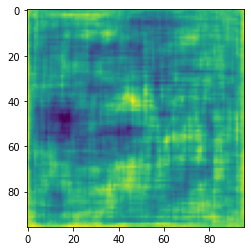

In [9]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [10]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50035787]], shape=(1, 1), dtype=float32)


## Define Loss

In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizer
만일 다른 해상도(`GENERATE_RES`)를 쓴다면 `learning_rate`를 변경할 필요가 있음 (다른 하이퍼파라미터도)

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

## Define Training
`@tf.function` 데코레이터는 이 훈련함수를 precompile 시켜 성능을 높여준다. 그리고 `tf.GradientTape()`을 사용하여 Generator와 Discriminator의 학습을 각각 진행할 수 있게 했다.

In [13]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


        gradients_of_generator = gen_tape.gradient(gen_loss,
                                                   generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                        discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                                generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                    discriminator.trainable_variables))
        
    return gen_loss,disc_loss

In [14]:
def train(dataset, epochs):
    fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
    start = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        epoch_elapsed = time.time() - epoch_start
        print(f'\rEpoch {epoch+1}, gen_loss={g_loss:.2f}, disc_loss={d_loss:.2f}, {hms_string(epoch_elapsed)}', end="")
        save_images(epoch, fixed_seed)

    elapsed = time.time() - start
    print(f'\nTraining time: {hms_string(elapsed)}')

## 실제 트레이닝
아래 셀을 실행하면 훈련이 시작된다 (시간이 무척 오래걸림 주의)

In [15]:
train(train_dataset, EPOCHS) # Constants에서 EPOCHS를 설정하라

Epoch 500, gen_loss=4.88, disc_loss=0.31, 0:00:01.70
Training time: 0:17:23.93


## Save Model

In [ ]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))

## Model Test
Output 폴더에 가면 에포크별로 생성한 이미지가 있다. 혹은 직접 생성하고 싶다면 아래 셀을 활용.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


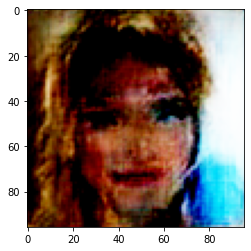

In [17]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,:])